In [67]:
#!g1.1
%pip install -r requirements.txt
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import umap

%matplotlib inline

In [2]:
#!g1.4
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 80
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
dataset_train = dl.FontsDataset(test=False, download=True)
dataset_test = dl.FontsDataset(test=True)

train_dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=256, shuffle=True, num_workers=0)

('A', '!paulmaul')


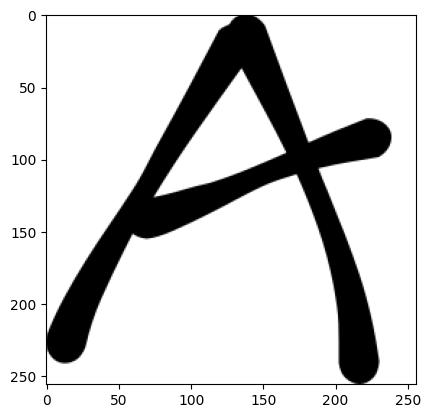

In [4]:
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray):
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    plt.imshow(img)
    
print(dataset_test[0][1:])
save_sampled(dataset_test[0][0], 'test_print.svg')
show_sampled(dataset_test[0][0])

## Определение рисователя прогресса

In [5]:
class Progresser:
    def __init__(self, _train_dataloader, split_num=4):
        self.epoch = 0
        self.train_ts, self.train_loss = [], []
        self.test_ts, self.test_loss = [], []
        self.interval = len(_train_dataloader) // split_num

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None):
        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        last_size = 0.5

        for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')
        last_train = str(self.train_loss[-1]) if len(self.train_loss) > 0 else ''
        last_test = str(self.test_loss[-1]) if len(self.test_loss) > 0 else ''

        ax1.plot(self.train_ts, self.train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
        ax1.plot(self.test_ts, self.test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')

        ax2.plot(
            self.train_ts[-int(len(self.train_ts)*last_size):], 
            self.train_loss[-int(len(self.train_loss)*last_size):], 
            c='darkblue', lw=3, label=f'train: {last_train}',
        )
        ax2.plot(
            self.test_ts[-int(len(self.test_ts)*last_size):], 
            self.test_loss[-int(len(self.test_loss)*last_size):], 
            c='green', marker='o', lw=5, label=f'test: {last_test}'
        )

        ax1.legend()
        ax2.legend()
        if save_to is None:
            plt.show() 
        else:
            plt.savefig(save_to)
            plt.show()
            plt.close()
    
    def add_train(self, ts, loss):
        self.train_ts.append(ts)
        self.train_loss.append(loss)

    def add_test(self, ts, loss):
        self.test_ts.append(ts)
        self.test_loss.append(loss)
        
    def reset(self):
        self.train_ts = []
        self.test_ts = []
        self.train_loss = []
        self.test_loss = []
        self.epoch = 0


progresser = Progresser(train_dataloader)

## Определение моделей

### Вспомогательные модули

In [6]:
class BnAndDropout(nn.Module):
    def __init__(self, features, p=0.15):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features=features)
        self.do = nn.Dropout(p)
    
    def forward(self, x):
        return self.do(self.bn(x))


class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x):
        return self.layer(x)


class TimeBlock(nn.Module):
    def __init__(self, f_in, f_out, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        self.layer = nn.Sequential(
            nn.Linear(f_in + time_emb_dim, f_out),
            nn.ReLU(),
            # BnAndDropout(f_out),
        )

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = torch.cat((x, t), dim=1)
        return self.layer(x)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


### Автоэнкодер с условием
и кодированием каждой линии предыдущей моделью

In [7]:
class CAE(nn.Module):
    activation = nn.Tanh

    def __init__(self, params, in_labels, line_size, activation=None):
        super().__init__()
        self.line_size = line_size
        
        encoder_params = params[:]
        encoder_params[0] += in_labels
        
        decoder_params = params[::-1]
        decoder_params[0] += in_labels

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1]))

        self.decoder = []
        for i in range(len(decoder_params) - 1):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def encode(self, x, labels):
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, labels), 1)
        x = self.encoder(x)
        return x

    def decode(self, z, labels):
        z = torch.cat((z, labels), 1)
        z = self.decoder(z)
        z = z.view(z.shape[0], -1, self.line_size)
        return z
    
    def forward(self, x, labels):
        z = self.encode(x, labels)
        return self.decode(z, labels)
        
    def loss(self, x_hat, x):
        mse = F.mse_loss(x_hat, x, reduction='sum')
        return mse / x.shape[0]
    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (images, labels, _) in enumerate(dataloader):
            images = torch.Tensor(images).to(device)
            labels = labels2one_hot(labels).to(device)

            output = self(images, labels)
            loss = self.loss(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        tmp_test_loss = []
        for images, labels, _ in dataloader:
            images = torch.Tensor(images).to(device)
            labels = labels2one_hot(labels).to(device)

            result = self(images, labels)
            loss = self.loss(result, images)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)

### Автоэнкодер с условием и skip connection
Ядро дифузионной модели. 

U - UNET-like\
С - conditional\
A - auto\
E - encoder

In [8]:
class UCAE(nn.Module):
    def __init__(self, params, in_labels, time_emb_dim=32):
        super().__init__()
        
        encoder_params = params[:]
        encoder_params[0] += in_labels
        
        decoder_params = params[::-1]
        decoder_params[0] += in_labels

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(TimeBlock(encoder_params[i], encoder_params[i + 1], time_emb_dim))

        self.decoder = []
        self.decoder.append(TimeBlock(decoder_params[0], decoder_params[1], time_emb_dim))
        for i in range(1, len(decoder_params) - 1):
            self.decoder.append(TimeBlock(decoder_params[i] * 2, decoder_params[i + 1], time_emb_dim))
        
        self.encoder = nn.ModuleList(self.encoder)
        self.decoder = nn.ModuleList(self.decoder)
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        
    def forward(self, x, labels, timestep):
        shape = x.shape
        t = self.time_mlp(timestep)
        x = torch.cat((x, labels), 1)
        accumulate = []
        for layer in self.encoder:
            x = layer(x, t)
            accumulate.append(x)
        accumulate.pop()
        
        x = torch.cat((x, labels), 1)
        x = self.decoder[0](x, t)
        
        for layer in self.decoder[1:]:
            connection = accumulate.pop()
            x = torch.cat((x, connection), 1)
            x = layer(x, t)
        return x
    
    def loss(self, y, y_hat):
        return F.mse_loss(y_hat, y, reduction='sum') / y.shape[0]

    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)]).to(device)

            output = self(inp_data, labels, t)
            loss = self.loss(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader:
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)], dtype=torch.int64).to(device)

            result = self(inp_data, labels, t)
            loss = self.loss(result, inp_data)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progreser.show_progress(epoch, epochs)

## Вспомогательные функции

In [9]:
def to_numpy(d):
    return d.cpu().detach().numpy()


ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}


def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()


def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)


def run(model, train_dl, test_dl, optimizer, scheduler, epochs, params, _epoch=0, run_name=None, trial=None, save=True):
    class_name = model.__class__.__name__
    if run_name is None:
        run_name = f'{class_name}_{SVG.ENCODE_HEIGHT}_{",".join(map(str, params))}'

    save_folder = Path('models') / class_name / run_name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    max_epoch = progresser.epoch + epochs

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, train_dl, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, test_dl, show=True)
        
        if save:
            torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})
        if _epoch == 1:
            if progresser.test_loss[-1] > progresser.test_loss[-2]:
                return
    

def setup_maker(model_type):
    def _inner(params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
        if model_type == 'cae':
            if line_size is None:
                raise Exception('line_size should be provided')
            model = CAE(params, ONE_HOT_LEN, line_size).to(device)
        elif model_type == 'ucae':
            model = UCAE(params, ONE_HOT_LEN).to(device)
        else:
            raise Exception('Unexpected model type')

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

        progresser.reset()

        return model, optimizer, scheduler

    return _inner

setup_cae = setup_maker('cae')
setup_ucae = setup_maker('ucae')

## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db_full.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 7e-6, 8e-4, log=True)
    p0 = trial.suggest_int('p0', 2000, 4500)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0]
    latent_size = trial.suggest_int('z', 100, 600)

    for i in range(1, 6):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    # step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_cae(
        params=params,
        lr=lr,
        weight_decay=3e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=0.96,
    )
    run(
        model=model, 
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=10,
        params=params,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db_full.sqlite3",
    study_name="cae_lr,7layers,10epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=2, show_progress_bar=True)

## Создание и запуск CAE

	0.4749041528919259	1703400	lr: 0.0001682220983081308, p0: 3115, p1: 2862, p2: 2212, p3: 975, p4: 692, p5: 548, z: 473

Loaded from file


CAE(
  (encoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_features=942, out_features=3900, bias=True)
        (1): Tanh()
      )
    )
    (1): Block(
      (layer): Sequential(
        (0): Linear(in_features=3900, out_features=3800, bias=True)
        (1): Tanh()
      )
    )
    (2): Block(
      (layer): Sequential(
        (0): Linear(in_features=3800, out_features=3700, bias=True)
        (1): Tanh()
      )
    )
    (3): Block(
      (layer): Sequential(
        (0): Linear(in_features=3700, out_features=2900, bias=True)
        (1): Tanh()
      )
    )
    (4): Block(
      (layer): Sequential(
        (0): Linear(in_features=2900, out_features=1800, bias=True)
        (1): Tanh()
      )
    )
    (5): Block(
      (layer): Sequential(
        (0): Linear(in_features=1800, out_features=400, bias=True)
        (1): Tanh()
      )
    )
  )
  (decoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_feature

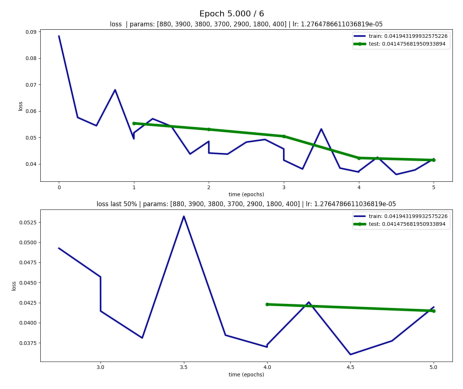

In [20]:
#!g1.4
GLIPH_WIDTH = 400
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 3900, 3800, 3700, 2900, 1800, GLIPH_WIDTH]

# lr = 1e-4
lr = 7e-6
# lr = 5e-7
# lr = 2.8e-7

model_cae_path = f'models/CAE/CAE_{SVG.ENCODE_HEIGHT}_{",".join(map(str,params))}/ckpt.pt'
model_cae, optimizer, scheduler = setup_cae(
    params=params,
    lr=lr,
    weight_decay=4e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=1,
    step_gamma=0.960,
)
if Path(model_cae_path).exists():
    print('Loaded from file')
    model_cae.load_state_dict(torch.load(model_cae_path))
    img = mpimg.imread(str(Path(model_cae_path).parent / '_loss.png'))
    plt.axis('off')
    plt.imshow(img)
else:
    print('Created new')
model_cae

## Тут пытаюсь подвинуть модели

In [15]:
state_dict = torch.load('models/CAE/CAE_80_880,3900,3800,3700,2900,1800,400/ckpt.pt')

In [37]:
with torch.no_grad():
    for i in range(1, len(model_cae.encoder)):
        model_cae.encoder[i].layer[0].weight.copy_(state_dict[f'encoder.{i}.layer.0.weight'])
        model_cae.encoder[i].layer[0].weight.requires_grad = False
        model_cae.encoder[i].layer[0].bias.copy_(state_dict[f'encoder.{i}.layer.0.bias'])
        model_cae.encoder[i].layer[0].bias.requires_grad = False
    for i in range(1, len(model_cae.decoder)):
        model_cae.decoder[i].layer[0].weight.copy_(state_dict[f'decoder.{i}.layer.0.weight'])
        model_cae.decoder[i].layer[0].weight.requires_grad = False
        model_cae.decoder[i].layer[0].bias.copy_(state_dict[f'decoder.{i}.layer.0.bias'])
        model_cae.decoder[i].layer[0].bias.requires_grad = False

In [39]:
with torch.no_grad():
    for i in range(1, len(model_cae.encoder)):
        model_cae.encoder[i].layer[0].weight.requires_grad = True
        model_cae.encoder[i].layer[0].bias.requires_grad = True
    for i in range(1, len(model_cae.decoder)):
        model_cae.decoder[i].layer[0].weight.requires_grad = True
        model_cae.decoder[i].layer[0].bias.requires_grad = True

In [22]:
for i in range(30):
    scheduler.step()

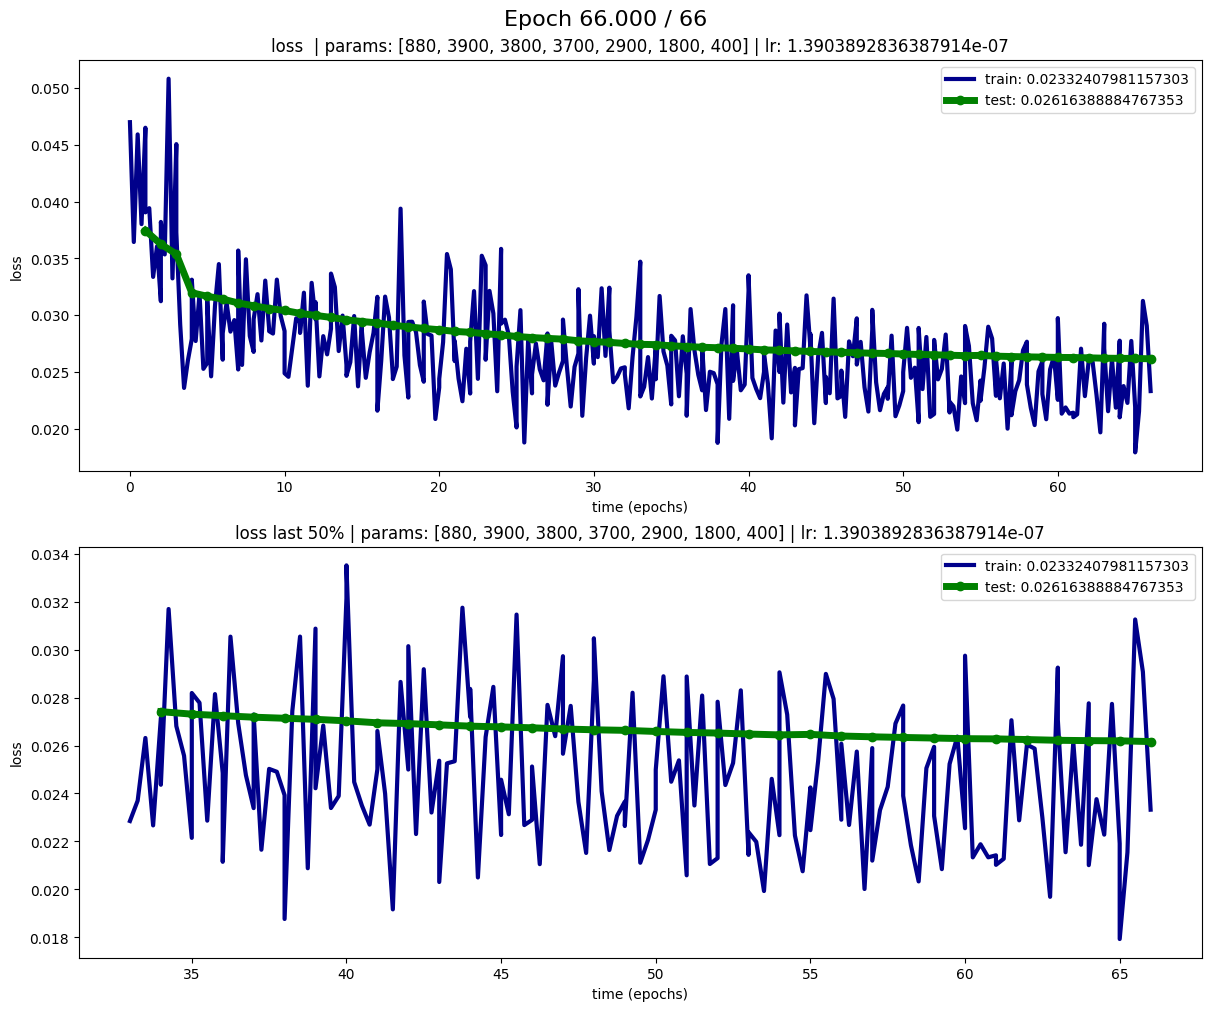

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [5:42:50<00:00, 342.84s/it]


In [24]:
#!g1.4
run(
    model=model_cae,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=60,
    params=params,
)

9000    k
9001    k
9002    k
9003    l
9004    l
9005    l
Name: letter, dtype: object


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_3432\1018516327.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


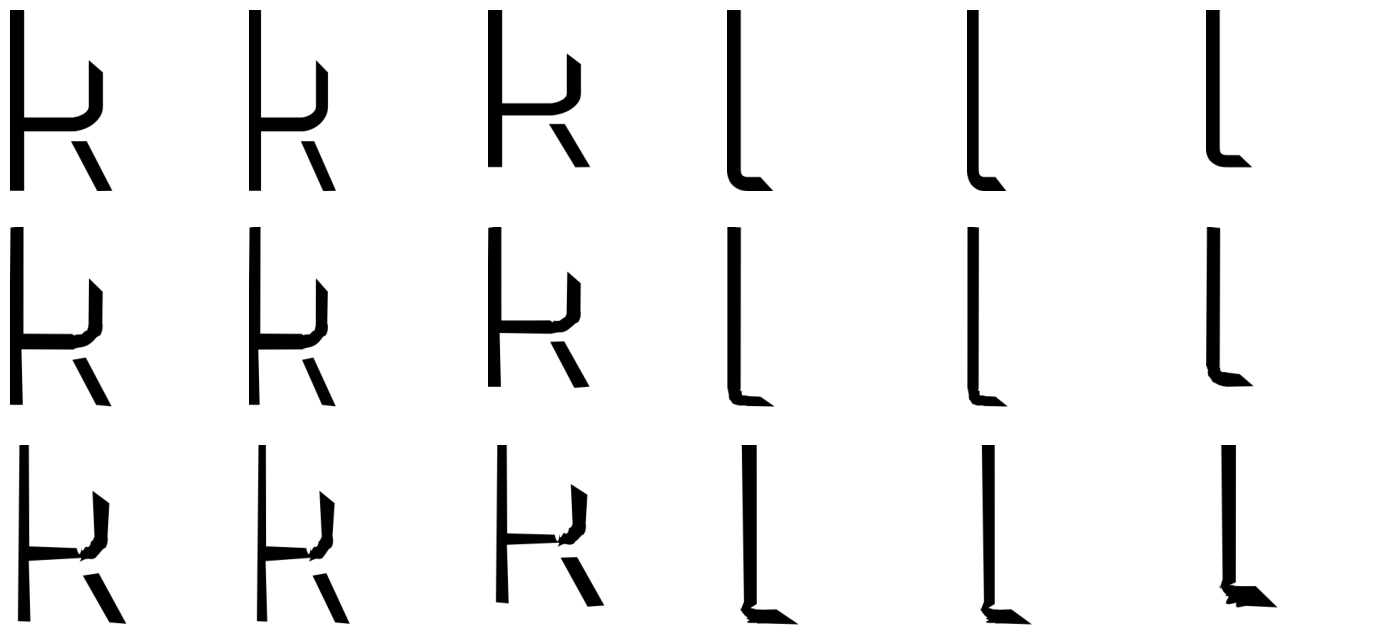

In [28]:
imgs_num = 6
plt.figure(figsize=(3 * imgs_num, 8))
plt.axis('off')


samples, labels, _ = dataset_train[1500*imgs_num:1501*imgs_num]
print(labels)
labels = labels2one_hot(labels).to(device)
model_cae.eval()
processed_samples = model_cae(torch.Tensor(samples).to(device), labels).cpu().detach().numpy()

a_labels = ['a'] * imgs_num
a_labels = labels2one_hot(a_labels).to(device)
a_samples = model_cae.encode(torch.Tensor(samples).to(device), labels)
a_samples = model_cae.decode(a_samples, a_labels).cpu().detach().numpy()

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    show_sampled(processed_samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, 2 * imgs_num + i + 1)
    plt.axis('off')
    show_sampled(a_samples[i])
plt.show()

In [29]:
def decode_img(d, label):
    model_cae.eval()
    single = False
    if isinstance(label, str):
        single = True
        d = torch.Tensor([d]).to(device)
        label = labels2one_hot([label]).to(device)
    with torch.no_grad():
        origin = model_cae.decode(d, label)
        if single:
            return origin[0]
        return origin

def encode_img(d, label):
    model_cae.eval()
    single = False
    if isinstance(label, str):
        single = True
        label = labels2one_hot([label]).to(device)
        d = torch.Tensor([d]).to(device)

    with torch.no_grad():
        image = model_cae.encode(d, label)
        if single:
            return image[0]
        return image

## UMAP проверка

#### Проверяю по лейблам

In [33]:
encoded_data = []
y_data = []
# there are too many images to do it by one execution
for inp_data, labels, _ in test_dataloader:
    inp_data = torch.Tensor(inp_data).to(device)
    y_data.append(labels)
    labels = labels2one_hot(labels).to(device)

    encoded_batch = encode_img(inp_data, labels)
    encoded_data.append(encoded_batch)

y_data = np.concatenate(y_data, axis=0)
encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
umap_model = umap.UMAP(n_neighbors=12)
embedding = umap_model.fit_transform(encoded_data)

del encoded_data

Data shape (227151, 400)


C:\Users\HYPERPC\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\HYPERPC\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


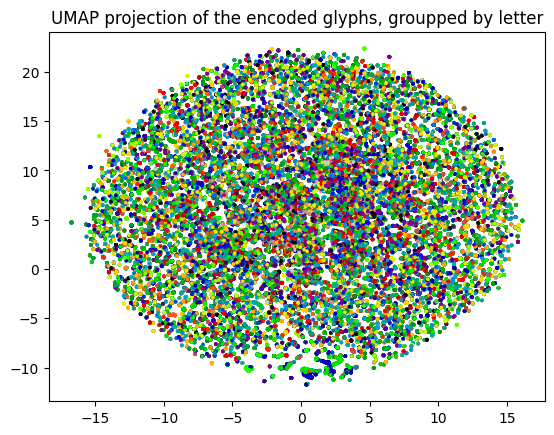

In [34]:
plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=to_numpy(labels2num(y_data)), 
    cmap='nipy_spectral', s=3
)
plt.title('UMAP projection of the encoded glyphs, groupped by letter');
plt.show()

#### Проверяю нa схожесть букв в одном шрифте

In [36]:
encoded_data = []
fonts_data = []
for i, (inp_data, labels, fonts) in enumerate(test_dataloader):
    inp_data = torch.Tensor(inp_data).to(device)
    labels = labels2one_hot(labels).to(device)
    fonts_data.append(fonts)

    encoded_batch = encode_img(inp_data, labels)
    encoded_data.append(encoded_batch)
    if i == 2:
        break

fonts_data = np.concatenate(fonts_data, axis=0)
encoded_data = to_numpy(torch.cat(encoded_data, 0))

embedding_fonts = umap_model.fit_transform(encoded_data)
del encoded_data

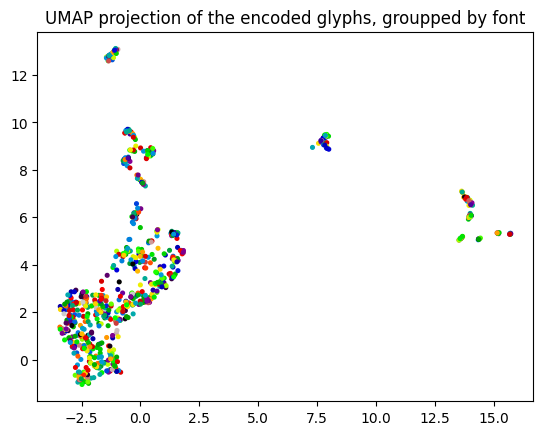

In [43]:
unique_fonts = np.unique(fonts_data).tolist()
colors = [unique_fonts.index(i) for i in fonts_data]

plt.scatter(
    embedding_fonts[:, 0], embedding_fonts[:, 1], 
    c=colors, 
    cmap='nipy_spectral', s=7
)
plt.title('UMAP projection of the encoded glyphs, groupped by font');
plt.show()

In [37]:
del embedding_fonts
del umap_model

## Дифузионная модель

In [38]:
#!g1.4
IMG_SIZE = 20

class Diffusion:
    def __init__(self, model_inner):
        self.T = 300
        self.betas = self.linear_beta_schedule(timesteps=self.T).to(device)

        # Pre-calculate different terms for closed form
        self.alphas = (1. - self.betas)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
        self.model = model_inner
    
    @staticmethod
    def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
        return torch.linspace(start, end, timesteps)

    @staticmethod
    def get_index_from_list(vals, t, x_shape):
        """ 
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def forward_diffusion_sample(self, x_0, t):
        """ 
        Takes an image and a timestep as input and 
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0).to(device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def get_loss(self, x_0, t):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.model(x_noisy, t)
        return F.l1_loss(noise, noise_pred)
        
    @torch.no_grad()
    def sample_timestep(self, x, t):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = self.get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self.get_index_from_list(self.posterior_variance, t, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise 

    @torch.no_grad()
    def sample_plot_image(self, encode_fn):
        # Sample noise
        img_size = IMG_SIZE
        img = torch.randn((1, 1, img_size, img_size), device=device)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T // num_images)

        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = self.sample_timestep(img, t)
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize+1)
                
                show_tensor_image(img.detach().cpu())
        plt.show()
    
    def state_dict(self):
        return self.model.state_dict()

e


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_21736\2739813190.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, (idx // stepsize) + 1)


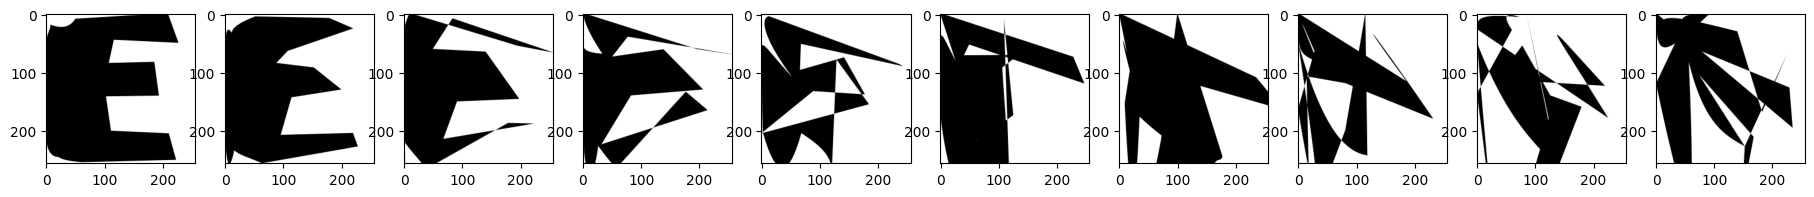

In [39]:
#!g1.4
diffusion = Diffusion(None, model_cae)

image = dataloader.x_test[0]
label = dataloader.y_test[0]
print(label)
image = encode_img(image, label)

plt.figure(figsize=(25, 20))
plt.axis('off')
num_images = 10

# stepsize = diffusion.T // num_images
stepsize = 1

# for idx in range(0, diffusion.T, stepsize):
for idx in range(0, 10):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1)
    image, noise = diffusion.forward_diffusion_sample(image, t)
    decoded_svg = to_numpy(decode_img(to_numpy(image), label))
    show_sampled(decoded_svg)

In [44]:
#!g1.4
params = [GLIPH_WIDTH, 2200, 2000, 1800, 1600, 1400, 1100, 800, 400]

model_d, optimizer, scheduler = setup_ucae(
    params=params,
    lr=1e-4,
    weight_decay=2e-5,
    step_size=3,    
    step_gamma=0.968,
)

diffusion = Diffusion(model_d, model_cae)

print("Num params: ", sum(p.numel() for p in model_d.parameters()))

Num params:  50771752


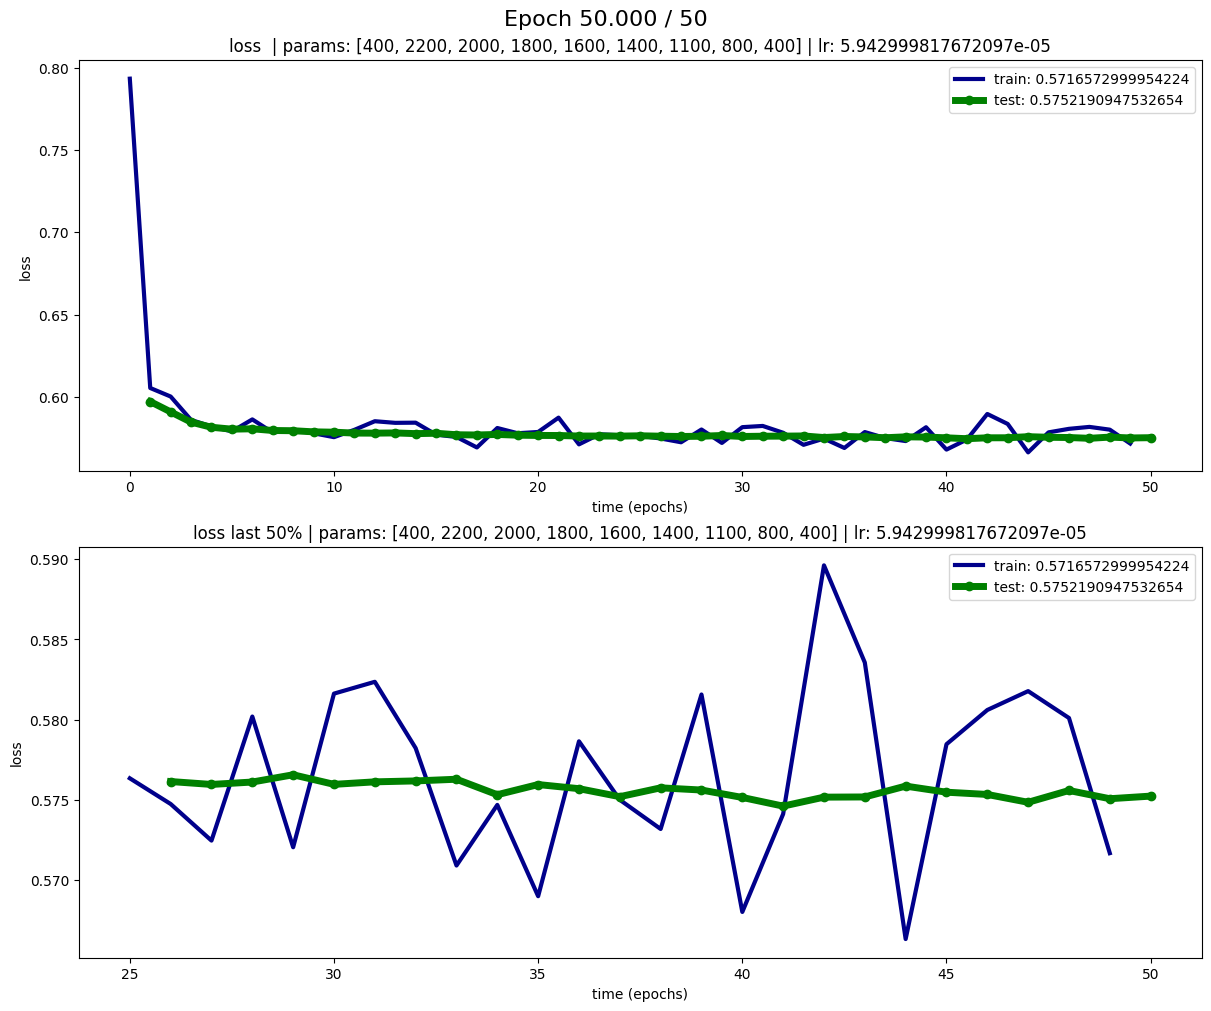

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [58:15<00:00, 69.91s/it]


In [45]:
#!g1.4
run(
    model=diffusion, 
    dataloader=dataloader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=50,
    params=params,
    batch_size=128,
)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_21736\93378467.py:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i // stepsize + 1)


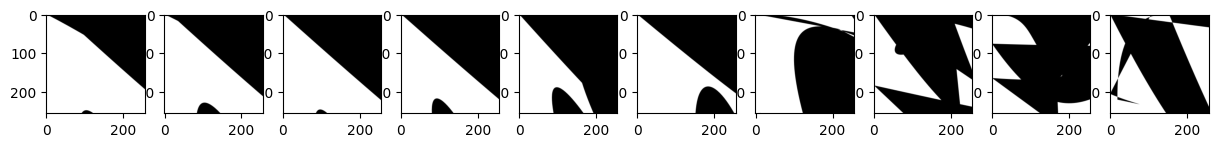

In [46]:
#!g1.4
diffusion.sample_plot_image()

In [19]:
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D
from torchvision.utils import save_image

In [40]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1
).to(device)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = GLIPH_WIDTH,
    timesteps = 1000,
    objective = 'pred_v'
).to(device)

diffusion_progresser = Progresser(split_num=100)

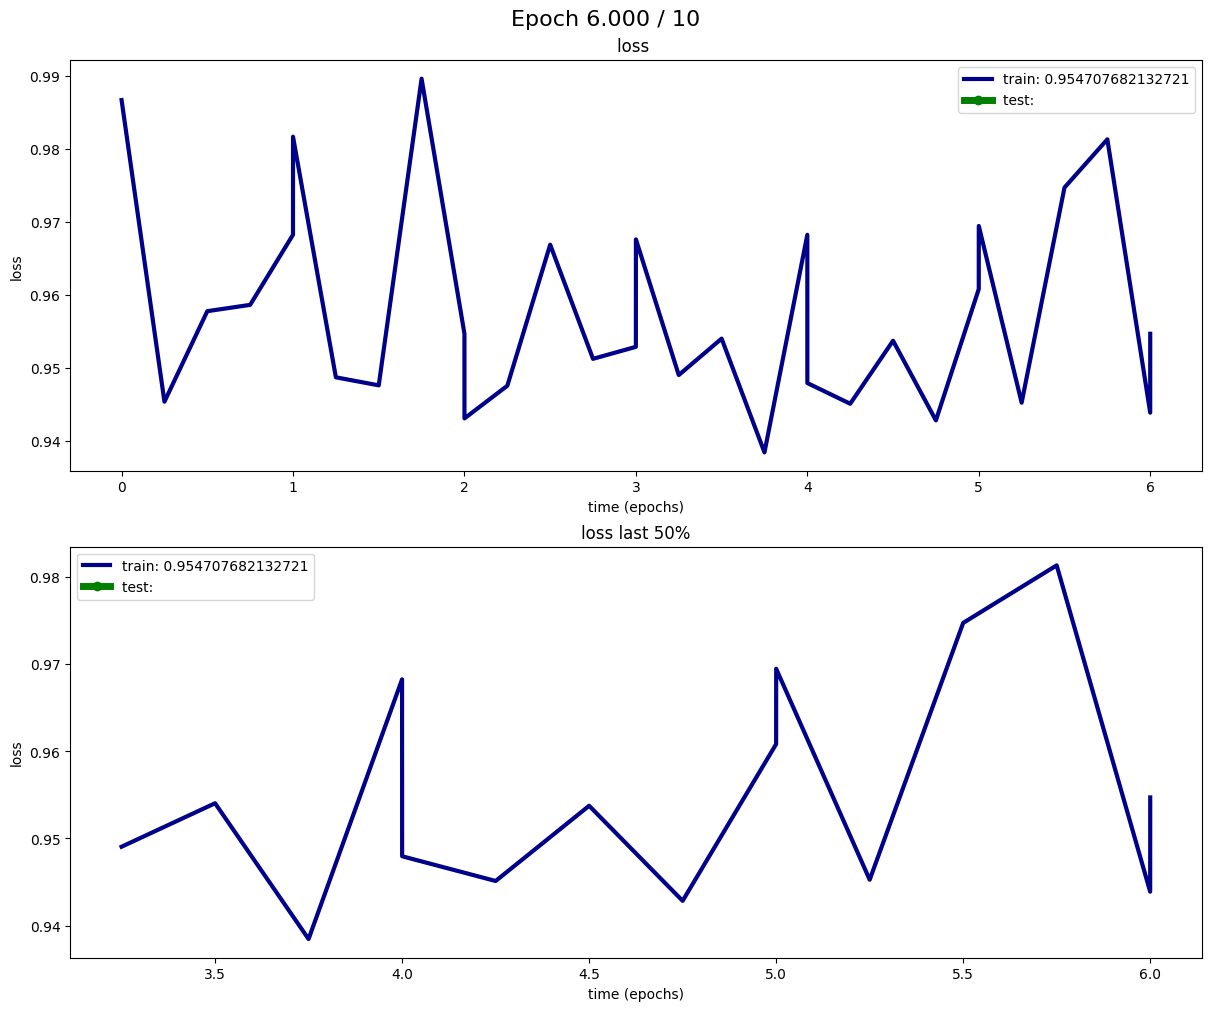

KeyboardInterrupt: 

In [42]:
num_batches = len(dataloader)
epochs = 10
for epoch in range(1, epochs):
    for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
        inp_data = torch.Tensor(inp_data).to(device)
        labels = labels2one_hot(labels).to(device)

        encoded_batch = encode_img(inp_data, labels)
        encoded_batch = encoded_batch.reshape(-1, 1, GLIPH_WIDTH)
        loss = diffusion(encoded_batch)
        loss.backward()

        if batch % progresser.interval == 0:
            t = epoch + (batch + 1) / num_batches
            diffusion_progresser.add_train(t, loss.item())
            diffusion_progresser.show_progress(t, epochs)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_24396\1081733614.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, imgs_num + 1, i + 1)


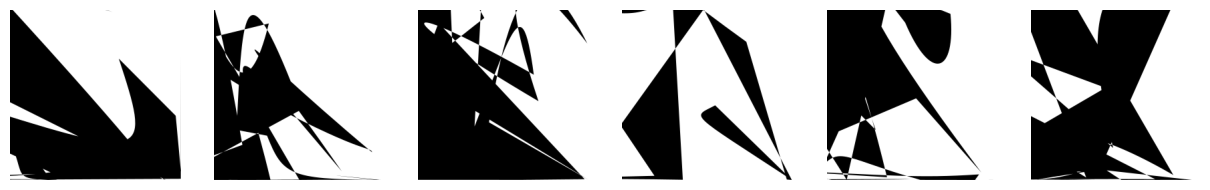

In [43]:
# after a lot of training

imgs_num = 6
plt.figure(figsize=(3 * imgs_num, 3))
plt.axis('off')

sampled_seq = diffusion.sample(batch_size = imgs_num)
a_labels = ['a'] * imgs_num
a_labels = labels2one_hot(a_labels).to(device)
decoded_images = to_numpy(decode_img(sampled_seq.reshape(imgs_num, GLIPH_WIDTH), a_labels))

for i in range(imgs_num):
    plt.subplot(1, imgs_num + 1, i + 1)
    plt.axis('off')
    show_sampled(decoded_images[i])